In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

c:\ProgramData\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
class LassoMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LassoMLP, self).__init__()
        
        self.beta = nn.Parameter(torch.ones(input_dim))
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.tanh(self.output_layer(x))
        return x

In [3]:
# Step 1: Define function to train or retrain the neural network
def train_network(model, X_train, y_train, lambda_, num_epochs=100, learning_rate=0.01):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        predictions = model(X_train)
        loss = criterion(predictions.squeeze(), y_train)
        
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += lambda_ * l1_norm

        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model

In [4]:
# Step 3: Use K-fold cross-validation to find the optimal lambda
def select_lambda(X, y, lambdas, k_folds=5):
    kf = KFold(n_splits=k_folds)
    best_lambda = None
    best_score = float('inf')

    for lambda_ in lambdas:
        print(f"Testing lambda = {lambda_}")
        scores = []

        for train_idx, val_idx in kf.split(X):
            model = LassoMLP(input_dim=X.shape[1], hidden_dim=64, output_dim=1)
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            trained_model = train_network(model, X_train, y_train, lambda_)
            model.eval()
            with torch.no_grad():
                predictions = trained_model(X_val)
                val_loss = mean_squared_error(y_val.numpy(), predictions.numpy())
                scores.append(val_loss)
                print(scores)

        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_lambda = lambda_

    return best_lambda

In [10]:
# Step 4-5: Iteratively prune features with zero β
def lasso_mlp_algorithm(X, y, output_dim, hidden_dim=64, num_epochs=100, learning_rate=0.001, lambdas=[0.1, 1, 10]):
    input_dim = X.shape[1]
    output_dim = input_dim
    termination = False
    lambdas = np.arange(0, 1.01, 0.1)
    lambdas = np.append(lambdas, 100)

    c = 0
    while not termination:
        print(f"Iteration {c + 1}:")
        model = LassoMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

        best_lambda = select_lambda(X, y, lambdas)
        print(f"Optimal lambda: {best_lambda}")

        trained_model = train_network(model, X, y, best_lambda, num_epochs=num_epochs, learning_rate=learning_rate)

        beta_estimates = model.beta.detach().cpu().numpy()
        
        non_zero_beta = beta_estimates != 0
        if np.sum(non_zero_beta) == input_dim:
            termination = True
        else:
            X = X[:, non_zero_beta]
            input_dim = X.shape[1]
            c += 1

    return trained_model, beta_estimates

In [6]:
df = pd.read_csv('pumadyn-32nm\puma32H.data', sep=',', header=None)

display(df.head())

x, y = df.iloc[:, :-1], df.iloc[:, -1]

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.736460,-1.761829,1.590594,-0.268853,0.572145,-1.941886,0.727704,1.869884,0.224501,-1.442215,...,2.220872,2.440442,0.510303,1.157391,0.265448,1.141465,0.356314,0.568853,1.954376,0.052627
1,-0.389711,0.342256,-1.522463,0.237098,-1.771509,-0.885488,-0.679111,-0.410219,-0.331288,2.092878,...,1.580327,0.809171,2.235141,1.517466,1.795334,0.929355,1.663727,0.754457,0.650492,0.001308
2,-0.269351,1.622452,-2.047811,1.720603,-1.749964,-1.618348,0.327188,-0.317671,0.046938,1.911881,...,1.723625,1.718983,2.438604,1.113059,2.180270,1.794781,0.627965,0.961728,1.258398,0.003834
3,0.256840,0.165040,-1.776401,1.723357,2.117348,-1.692605,1.077334,1.761624,-0.333281,1.573860,...,1.369922,1.528851,1.901706,2.222391,0.968513,0.546513,2.236340,1.412382,1.898374,-0.002010
4,0.968270,1.834561,0.299747,0.308144,0.064617,2.174855,-1.213028,-1.563548,-2.277270,-0.059009,...,1.171433,2.273871,2.199479,0.646400,0.302676,1.323917,2.324899,0.334220,0.491228,0.015778


In [7]:
x_embeddings = torch.tensor(x.values).float()
y_embeddings = torch.tensor(y.values).float()
y_embeddings = y_embeddings.view(-1, 1)

In [8]:
print(x_embeddings.shape, y_embeddings.shape)

torch.Size([4499, 32]) torch.Size([4499, 1])


In [11]:
print("Training the LASSO-MLP algorithm...")
model, final_beta = lasso_mlp_algorithm(x_embeddings, y_embeddings, output_dim=1)

print("Final β values:", final_beta)

Training the LASSO-MLP algorithm...
Iteration 1:
Testing lambda = 0.0
Epoch [10/100], Loss: 0.0146
Epoch [20/100], Loss: 0.0050
Epoch [30/100], Loss: 0.0016
Epoch [40/100], Loss: 0.0011
Epoch [50/100], Loss: 0.0010
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0009
Epoch [100/100], Loss: 0.0009
[0.00095440564]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0053
Epoch [20/100], Loss: 0.0038
Epoch [30/100], Loss: 0.0020
Epoch [40/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0010
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0010
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0009
Epoch [100/100], Loss: 0.0009
[0.00095440564, 0.00086749287]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0075
Epoch [20/100], Loss: 0.0040
Epoch [30/100], Loss: 0.0016
Epoch [40/100], Loss: 0.0011
Epoch [50/100], Loss: 0.0010
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0009
Epoch [100/100], Loss: 0.0009
[0.00095440564, 0.00086749287, 0.0009218902]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0058
Epoch [20/100], Loss: 0.0026
Epoch [30/100], Loss: 0.0016
Epoch [40/100], Loss: 0.0013
Epoch [50/100], Loss: 0.0011
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0009
Epoch [100/100], Loss: 0.0009
[0.00095440564, 0.00086749287, 0.0009218902, 0.0008895177]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0142
Epoch [20/100], Loss: 0.0034
Epoch [30/100], Loss: 0.0017
Epoch [40/100], Loss: 0.0011
Epoch [50/100], Loss: 0.0010
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0009
Epoch [100/100], Loss: 0.0009
[0.00095440564, 0.00086749287, 0.0009218902, 0.0008895177, 0.00091778795]
Testing lambda = 0.1


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 12.9329
Epoch [20/100], Loss: 7.9886
Epoch [30/100], Loss: 4.8703
Epoch [40/100], Loss: 3.5403
Epoch [50/100], Loss: 2.6692
Epoch [60/100], Loss: 2.2582
Epoch [70/100], Loss: 1.8374
Epoch [80/100], Loss: 1.4924
Epoch [90/100], Loss: 1.1665
Epoch [100/100], Loss: 0.8153
[0.0009072126]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 12.8749
Epoch [20/100], Loss: 7.9572
Epoch [30/100], Loss: 4.8877
Epoch [40/100], Loss: 3.5539
Epoch [50/100], Loss: 2.6618
Epoch [60/100], Loss: 2.2674
Epoch [70/100], Loss: 1.8414
Epoch [80/100], Loss: 1.4814
Epoch [90/100], Loss: 1.1621
Epoch [100/100], Loss: 0.8255
[0.0009072126, 0.00083131925]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 13.0383
Epoch [20/100], Loss: 8.0399
Epoch [30/100], Loss: 4.9104
Epoch [40/100], Loss: 3.5377
Epoch [50/100], Loss: 2.6740
Epoch [60/100], Loss: 2.2600
Epoch [70/100], Loss: 1.8446
Epoch [80/100], Loss: 1.4956
Epoch [90/100], Loss: 1.1652
Epoch [100/100], Loss: 0.8229
[0.0009072126, 0.00083131925, 0.0009036297]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 12.9086
Epoch [20/100], Loss: 8.0786
Epoch [30/100], Loss: 4.9359
Epoch [40/100], Loss: 3.5642
Epoch [50/100], Loss: 2.6823
Epoch [60/100], Loss: 2.2833
Epoch [70/100], Loss: 1.8490
Epoch [80/100], Loss: 1.5118
Epoch [90/100], Loss: 1.1814
Epoch [100/100], Loss: 0.8326
[0.0009072126, 0.00083131925, 0.0009036297, 0.00086987886]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 13.1341
Epoch [20/100], Loss: 8.1134
Epoch [30/100], Loss: 4.9123
Epoch [40/100], Loss: 3.5366
Epoch [50/100], Loss: 2.6679
Epoch [60/100], Loss: 2.2526
Epoch [70/100], Loss: 1.8302
Epoch [80/100], Loss: 1.4828
Epoch [90/100], Loss: 1.1574
Epoch [100/100], Loss: 0.8050
[0.0009072126, 0.00083131925, 0.0009036297, 0.00086987886, 0.0009140195]
Testing lambda = 0.2


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 26.1592
Epoch [20/100], Loss: 16.0077
Epoch [30/100], Loss: 9.8067
Epoch [40/100], Loss: 7.0971
Epoch [50/100], Loss: 5.3315
Epoch [60/100], Loss: 4.5736
Epoch [70/100], Loss: 3.6742
Epoch [80/100], Loss: 3.0144
Epoch [90/100], Loss: 2.3426
Epoch [100/100], Loss: 1.6424
[0.0009078826]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 25.6717
Epoch [20/100], Loss: 15.9601
Epoch [30/100], Loss: 9.7985
Epoch [40/100], Loss: 7.0795
Epoch [50/100], Loss: 5.3285
Epoch [60/100], Loss: 4.5462
Epoch [70/100], Loss: 3.6627
Epoch [80/100], Loss: 3.0521
Epoch [90/100], Loss: 2.3539
Epoch [100/100], Loss: 1.6462
[0.0009078826, 0.0008246654]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 25.8618
Epoch [20/100], Loss: 15.8949
Epoch [30/100], Loss: 9.7718
Epoch [40/100], Loss: 7.1470
Epoch [50/100], Loss: 5.3085
Epoch [60/100], Loss: 4.5734
Epoch [70/100], Loss: 3.6750
Epoch [80/100], Loss: 3.0354
Epoch [90/100], Loss: 2.3403
Epoch [100/100], Loss: 1.6681
[0.0009078826, 0.0008246654, 0.00090374536]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 25.6123
Epoch [20/100], Loss: 16.0554
Epoch [30/100], Loss: 9.8011
Epoch [40/100], Loss: 7.0486
Epoch [50/100], Loss: 5.3243
Epoch [60/100], Loss: 4.4931
Epoch [70/100], Loss: 3.6973
Epoch [80/100], Loss: 2.9859
Epoch [90/100], Loss: 2.3371
Epoch [100/100], Loss: 1.6344
[0.0009078826, 0.0008246654, 0.00090374536, 0.00087667105]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 25.6117
Epoch [20/100], Loss: 15.8216
Epoch [30/100], Loss: 9.7353
Epoch [40/100], Loss: 7.1005
Epoch [50/100], Loss: 5.3615
Epoch [60/100], Loss: 4.5659
Epoch [70/100], Loss: 3.7161
Epoch [80/100], Loss: 3.0372
Epoch [90/100], Loss: 2.3532
Epoch [100/100], Loss: 1.6800
[0.0009078826, 0.0008246654, 0.00090374536, 0.00087667105, 0.0009055184]
Testing lambda = 0.30000000000000004


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 38.5354
Epoch [20/100], Loss: 24.0840
Epoch [30/100], Loss: 14.8131
Epoch [40/100], Loss: 10.6170
Epoch [50/100], Loss: 7.9790
Epoch [60/100], Loss: 6.8352
Epoch [70/100], Loss: 5.5935
Epoch [80/100], Loss: 4.5382
Epoch [90/100], Loss: 3.5029
Epoch [100/100], Loss: 2.4926
[0.00090646924]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 39.6339
Epoch [20/100], Loss: 24.3138
Epoch [30/100], Loss: 14.7613
Epoch [40/100], Loss: 10.7176
Epoch [50/100], Loss: 7.9857
Epoch [60/100], Loss: 6.7794
Epoch [70/100], Loss: 5.5333
Epoch [80/100], Loss: 4.5184
Epoch [90/100], Loss: 3.4933
Epoch [100/100], Loss: 2.4620
[0.00090646924, 0.0008232819]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 38.5609
Epoch [20/100], Loss: 23.8763
Epoch [30/100], Loss: 14.6515
Epoch [40/100], Loss: 10.6602
Epoch [50/100], Loss: 8.0457
Epoch [60/100], Loss: 6.8094
Epoch [70/100], Loss: 5.5494
Epoch [80/100], Loss: 4.4955
Epoch [90/100], Loss: 3.5161
Epoch [100/100], Loss: 2.4856
[0.00090646924, 0.0008232819, 0.0009035363]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 38.7959
Epoch [20/100], Loss: 24.0579
Epoch [30/100], Loss: 14.7697
Epoch [40/100], Loss: 10.6838
Epoch [50/100], Loss: 8.0311
Epoch [60/100], Loss: 6.8716
Epoch [70/100], Loss: 5.5533
Epoch [80/100], Loss: 4.5398
Epoch [90/100], Loss: 3.5277
Epoch [100/100], Loss: 2.5189
[0.00090646924, 0.0008232819, 0.0009035363, 0.0008706108]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 39.4519
Epoch [20/100], Loss: 24.2739
Epoch [30/100], Loss: 14.8505
Epoch [40/100], Loss: 10.8050
Epoch [50/100], Loss: 8.0610
Epoch [60/100], Loss: 6.8094
Epoch [70/100], Loss: 5.5381
Epoch [80/100], Loss: 4.5329
Epoch [90/100], Loss: 3.5065
Epoch [100/100], Loss: 2.5069
[0.00090646924, 0.0008232819, 0.0009035363, 0.0008706108, 0.0009045516]
Testing lambda = 0.4


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 51.8358
Epoch [20/100], Loss: 32.3364
Epoch [30/100], Loss: 19.7876
Epoch [40/100], Loss: 14.3153
Epoch [50/100], Loss: 10.6352
Epoch [60/100], Loss: 9.1590
Epoch [70/100], Loss: 7.4030
Epoch [80/100], Loss: 6.0574
Epoch [90/100], Loss: 4.7285
Epoch [100/100], Loss: 3.2947
[0.0009123664]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 52.0322
Epoch [20/100], Loss: 32.3943
Epoch [30/100], Loss: 19.7532
Epoch [40/100], Loss: 14.2691
Epoch [50/100], Loss: 10.6631
Epoch [60/100], Loss: 9.1735
Epoch [70/100], Loss: 7.3411
Epoch [80/100], Loss: 6.0591
Epoch [90/100], Loss: 4.7018
Epoch [100/100], Loss: 3.2813
[0.0009123664, 0.00082271954]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 52.5067
Epoch [20/100], Loss: 32.3444
Epoch [30/100], Loss: 19.7727
Epoch [40/100], Loss: 14.2663
Epoch [50/100], Loss: 10.6696
Epoch [60/100], Loss: 9.1394
Epoch [70/100], Loss: 7.3901
Epoch [80/100], Loss: 6.0573
Epoch [90/100], Loss: 4.6479
Epoch [100/100], Loss: 3.2925
[0.0009123664, 0.00082271954, 0.00090315036]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 51.1128
Epoch [20/100], Loss: 32.0639
Epoch [30/100], Loss: 19.6531
Epoch [40/100], Loss: 14.2077
Epoch [50/100], Loss: 10.7073
Epoch [60/100], Loss: 9.0529
Epoch [70/100], Loss: 7.4394
Epoch [80/100], Loss: 6.0487
Epoch [90/100], Loss: 4.6635
Epoch [100/100], Loss: 3.3430
[0.0009123664, 0.00082271954, 0.00090315036, 0.000872242]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 52.0775
Epoch [20/100], Loss: 32.0749
Epoch [30/100], Loss: 19.5465
Epoch [40/100], Loss: 14.2607
Epoch [50/100], Loss: 10.7055
Epoch [60/100], Loss: 9.1188
Epoch [70/100], Loss: 7.3720
Epoch [80/100], Loss: 6.0394
Epoch [90/100], Loss: 4.7082
Epoch [100/100], Loss: 3.3274
[0.0009123664, 0.00082271954, 0.00090315036, 0.000872242, 0.00090407266]
Testing lambda = 0.5


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 64.9063
Epoch [20/100], Loss: 40.4005
Epoch [30/100], Loss: 24.7330
Epoch [40/100], Loss: 17.7582
Epoch [50/100], Loss: 13.3521
Epoch [60/100], Loss: 11.4882
Epoch [70/100], Loss: 9.3313
Epoch [80/100], Loss: 7.6296
Epoch [90/100], Loss: 5.9312
Epoch [100/100], Loss: 4.1919
[0.0009084311]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 64.7457
Epoch [20/100], Loss: 40.0082
Epoch [30/100], Loss: 24.4940
Epoch [40/100], Loss: 17.8211
Epoch [50/100], Loss: 13.4161
Epoch [60/100], Loss: 11.3742
Epoch [70/100], Loss: 9.2607
Epoch [80/100], Loss: 7.6368
Epoch [90/100], Loss: 5.7853
Epoch [100/100], Loss: 4.1790
[0.0009084311, 0.0008212062]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 64.5442
Epoch [20/100], Loss: 40.1805
Epoch [30/100], Loss: 24.8021
Epoch [40/100], Loss: 17.8703
Epoch [50/100], Loss: 13.3584
Epoch [60/100], Loss: 11.4482
Epoch [70/100], Loss: 9.1861
Epoch [80/100], Loss: 7.5069
Epoch [90/100], Loss: 5.8538
Epoch [100/100], Loss: 4.1412
[0.0009084311, 0.0008212062, 0.0009057853]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 64.2561
Epoch [20/100], Loss: 40.1647
Epoch [30/100], Loss: 24.8167
Epoch [40/100], Loss: 18.0227
Epoch [50/100], Loss: 13.3893
Epoch [60/100], Loss: 11.4132
Epoch [70/100], Loss: 9.2893
Epoch [80/100], Loss: 7.6119
Epoch [90/100], Loss: 5.8878
Epoch [100/100], Loss: 4.1991
[0.0009084311, 0.0008212062, 0.0009057853, 0.00087080867]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 65.6697
Epoch [20/100], Loss: 40.8236
Epoch [30/100], Loss: 24.7503
Epoch [40/100], Loss: 17.9949
Epoch [50/100], Loss: 13.5188
Epoch [60/100], Loss: 11.5127
Epoch [70/100], Loss: 9.4155
Epoch [80/100], Loss: 7.6148
Epoch [90/100], Loss: 5.9863
Epoch [100/100], Loss: 4.1770
[0.0009084311, 0.0008212062, 0.0009057853, 0.00087080867, 0.00090499106]
Testing lambda = 0.6000000000000001


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 77.3962
Epoch [20/100], Loss: 48.0368
Epoch [30/100], Loss: 29.4555
Epoch [40/100], Loss: 21.6909
Epoch [50/100], Loss: 16.0233
Epoch [60/100], Loss: 13.8274
Epoch [70/100], Loss: 11.1676
Epoch [80/100], Loss: 9.1125
Epoch [90/100], Loss: 7.0838
Epoch [100/100], Loss: 5.0279
[0.0009086384]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 76.8755
Epoch [20/100], Loss: 48.0474
Epoch [30/100], Loss: 29.5671
Epoch [40/100], Loss: 21.3625
Epoch [50/100], Loss: 16.0500
Epoch [60/100], Loss: 13.7255
Epoch [70/100], Loss: 11.1335
Epoch [80/100], Loss: 9.1636
Epoch [90/100], Loss: 7.1030
Epoch [100/100], Loss: 5.0659
[0.0009086384, 0.000828819]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 77.6055
Epoch [20/100], Loss: 48.3803
Epoch [30/100], Loss: 29.6907
Epoch [40/100], Loss: 21.5085
Epoch [50/100], Loss: 16.0175
Epoch [60/100], Loss: 13.7656
Epoch [70/100], Loss: 11.0771
Epoch [80/100], Loss: 9.0651
Epoch [90/100], Loss: 7.0179
Epoch [100/100], Loss: 4.9489
[0.0009086384, 0.000828819, 0.00090375176]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 77.1633
Epoch [20/100], Loss: 48.2306
Epoch [30/100], Loss: 29.6926
Epoch [40/100], Loss: 21.5434
Epoch [50/100], Loss: 16.1428
Epoch [60/100], Loss: 13.7816
Epoch [70/100], Loss: 11.1911
Epoch [80/100], Loss: 9.1443
Epoch [90/100], Loss: 7.0152
Epoch [100/100], Loss: 5.0168
[0.0009086384, 0.000828819, 0.00090375176, 0.00087228115]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 77.8208
Epoch [20/100], Loss: 48.5636
Epoch [30/100], Loss: 29.8786
Epoch [40/100], Loss: 21.4121
Epoch [50/100], Loss: 16.0283
Epoch [60/100], Loss: 13.6478
Epoch [70/100], Loss: 11.0571
Epoch [80/100], Loss: 9.1071
Epoch [90/100], Loss: 6.9830
Epoch [100/100], Loss: 4.9577
[0.0009086384, 0.000828819, 0.00090375176, 0.00087228115, 0.00090910867]
Testing lambda = 0.7000000000000001


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 90.9110
Epoch [20/100], Loss: 56.0764
Epoch [30/100], Loss: 34.3577
Epoch [40/100], Loss: 25.0506
Epoch [50/100], Loss: 18.7505
Epoch [60/100], Loss: 16.1418
Epoch [70/100], Loss: 13.0862
Epoch [80/100], Loss: 10.6385
Epoch [90/100], Loss: 8.3420
Epoch [100/100], Loss: 5.8432
[0.00090684585]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 91.4285
Epoch [20/100], Loss: 56.5182
Epoch [30/100], Loss: 34.3439
Epoch [40/100], Loss: 24.7804
Epoch [50/100], Loss: 18.6670
Epoch [60/100], Loss: 16.0285
Epoch [70/100], Loss: 12.9131
Epoch [80/100], Loss: 10.5313
Epoch [90/100], Loss: 8.1458
Epoch [100/100], Loss: 5.7868
[0.00090684585, 0.0008229715]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 91.2087
Epoch [20/100], Loss: 56.5777
Epoch [30/100], Loss: 34.4886
Epoch [40/100], Loss: 25.1514
Epoch [50/100], Loss: 18.6287
Epoch [60/100], Loss: 15.9141
Epoch [70/100], Loss: 12.9704
Epoch [80/100], Loss: 10.4758
Epoch [90/100], Loss: 8.2499
Epoch [100/100], Loss: 5.7599
[0.00090684585, 0.0008229715, 0.0009053076]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 91.6495
Epoch [20/100], Loss: 56.2950
Epoch [30/100], Loss: 34.5676
Epoch [40/100], Loss: 25.0275
Epoch [50/100], Loss: 18.6238
Epoch [60/100], Loss: 16.0346
Epoch [70/100], Loss: 12.8945
Epoch [80/100], Loss: 10.5793
Epoch [90/100], Loss: 8.1623
Epoch [100/100], Loss: 5.7392
[0.00090684585, 0.0008229715, 0.0009053076, 0.00087438314]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 91.4561
Epoch [20/100], Loss: 56.5504
Epoch [30/100], Loss: 34.3183
Epoch [40/100], Loss: 25.1233
Epoch [50/100], Loss: 18.7094
Epoch [60/100], Loss: 15.8663
Epoch [70/100], Loss: 12.9587
Epoch [80/100], Loss: 10.6664
Epoch [90/100], Loss: 8.2341
Epoch [100/100], Loss: 5.8703
[0.00090684585, 0.0008229715, 0.0009053076, 0.00087438314, 0.00090389664]
Testing lambda = 0.8


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 101.7560
Epoch [20/100], Loss: 63.2653
Epoch [30/100], Loss: 39.1874
Epoch [40/100], Loss: 28.4823
Epoch [50/100], Loss: 21.3537
Epoch [60/100], Loss: 18.2367
Epoch [70/100], Loss: 14.7973
Epoch [80/100], Loss: 12.2017
Epoch [90/100], Loss: 9.4275
Epoch [100/100], Loss: 6.7583
[0.00090700015]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 104.3459
Epoch [20/100], Loss: 64.7821
Epoch [30/100], Loss: 39.3309
Epoch [40/100], Loss: 28.5248
Epoch [50/100], Loss: 21.3263
Epoch [60/100], Loss: 18.2690
Epoch [70/100], Loss: 14.8390
Epoch [80/100], Loss: 12.1277
Epoch [90/100], Loss: 9.4180
Epoch [100/100], Loss: 6.7361
[0.00090700015, 0.0008429237]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 104.9837
Epoch [20/100], Loss: 64.6912
Epoch [30/100], Loss: 39.6638
Epoch [40/100], Loss: 28.8382
Epoch [50/100], Loss: 21.2867
Epoch [60/100], Loss: 18.4215
Epoch [70/100], Loss: 14.8088
Epoch [80/100], Loss: 12.1941
Epoch [90/100], Loss: 9.3309
Epoch [100/100], Loss: 6.6898
[0.00090700015, 0.0008429237, 0.0009050521]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 104.2284
Epoch [20/100], Loss: 63.9477
Epoch [30/100], Loss: 39.4953
Epoch [40/100], Loss: 28.6329
Epoch [50/100], Loss: 21.4199
Epoch [60/100], Loss: 18.3193
Epoch [70/100], Loss: 14.8483
Epoch [80/100], Loss: 12.1113
Epoch [90/100], Loss: 9.3889
Epoch [100/100], Loss: 6.5839
[0.00090700015, 0.0008429237, 0.0009050521, 0.00087073643]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 104.5872
Epoch [20/100], Loss: 64.1989
Epoch [30/100], Loss: 39.1968
Epoch [40/100], Loss: 28.6998
Epoch [50/100], Loss: 21.2441
Epoch [60/100], Loss: 18.2965
Epoch [70/100], Loss: 14.8452
Epoch [80/100], Loss: 12.2137
Epoch [90/100], Loss: 9.3717
Epoch [100/100], Loss: 6.6747
[0.00090700015, 0.0008429237, 0.0009050521, 0.00087073643, 0.00090993213]
Testing lambda = 0.9


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 116.5281
Epoch [20/100], Loss: 72.2634
Epoch [30/100], Loss: 44.3796
Epoch [40/100], Loss: 32.1653
Epoch [50/100], Loss: 24.1231
Epoch [60/100], Loss: 20.5884
Epoch [70/100], Loss: 16.7930
Epoch [80/100], Loss: 13.7427
Epoch [90/100], Loss: 10.5440
Epoch [100/100], Loss: 7.6483
[0.0009071795]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 115.7104
Epoch [20/100], Loss: 72.6735
Epoch [30/100], Loss: 44.3430
Epoch [40/100], Loss: 32.2737
Epoch [50/100], Loss: 24.0008
Epoch [60/100], Loss: 20.4099
Epoch [70/100], Loss: 16.6420
Epoch [80/100], Loss: 13.7083
Epoch [90/100], Loss: 10.5043
Epoch [100/100], Loss: 7.5558
[0.0009071795, 0.00082559267]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 116.3146
Epoch [20/100], Loss: 72.1778
Epoch [30/100], Loss: 44.6275
Epoch [40/100], Loss: 32.2098
Epoch [50/100], Loss: 24.0463
Epoch [60/100], Loss: 20.7005
Epoch [70/100], Loss: 16.8186
Epoch [80/100], Loss: 13.7802
Epoch [90/100], Loss: 10.7262
Epoch [100/100], Loss: 7.6078
[0.0009071795, 0.00082559267, 0.00090478995]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 117.0796
Epoch [20/100], Loss: 72.8696
Epoch [30/100], Loss: 44.6764
Epoch [40/100], Loss: 32.5683
Epoch [50/100], Loss: 24.0008
Epoch [60/100], Loss: 20.5783
Epoch [70/100], Loss: 16.7948
Epoch [80/100], Loss: 13.5702
Epoch [90/100], Loss: 10.5734
Epoch [100/100], Loss: 7.5958
[0.0009071795, 0.00082559267, 0.00090478995, 0.00087049045]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 115.5990
Epoch [20/100], Loss: 72.0270
Epoch [30/100], Loss: 44.2687
Epoch [40/100], Loss: 32.2415
Epoch [50/100], Loss: 24.0424
Epoch [60/100], Loss: 20.6002
Epoch [70/100], Loss: 16.7401
Epoch [80/100], Loss: 13.5990
Epoch [90/100], Loss: 10.5894
Epoch [100/100], Loss: 7.4760
[0.0009071795, 0.00082559267, 0.00090478995, 0.00087049045, 0.00090876676]
Testing lambda = 1.0


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 128.7944
Epoch [20/100], Loss: 80.2498
Epoch [30/100], Loss: 49.3302
Epoch [40/100], Loss: 35.4721
Epoch [50/100], Loss: 26.7898
Epoch [60/100], Loss: 22.9413
Epoch [70/100], Loss: 18.6363
Epoch [80/100], Loss: 15.3020
Epoch [90/100], Loss: 11.8739
Epoch [100/100], Loss: 8.3990
[0.0009082476]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 129.3957
Epoch [20/100], Loss: 80.5891
Epoch [30/100], Loss: 49.4916
Epoch [40/100], Loss: 35.6376
Epoch [50/100], Loss: 26.6972
Epoch [60/100], Loss: 22.9082
Epoch [70/100], Loss: 18.5803
Epoch [80/100], Loss: 15.0973
Epoch [90/100], Loss: 11.8872
Epoch [100/100], Loss: 8.3742
[0.0009082476, 0.0008280192]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 128.3208
Epoch [20/100], Loss: 79.7457
Epoch [30/100], Loss: 49.1128
Epoch [40/100], Loss: 35.3571
Epoch [50/100], Loss: 26.6991
Epoch [60/100], Loss: 23.1323
Epoch [70/100], Loss: 18.5131
Epoch [80/100], Loss: 15.1932
Epoch [90/100], Loss: 11.8503
Epoch [100/100], Loss: 8.4807
[0.0009082476, 0.0008280192, 0.0009105166]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 130.2654
Epoch [20/100], Loss: 80.4717
Epoch [30/100], Loss: 49.1964
Epoch [40/100], Loss: 35.4400
Epoch [50/100], Loss: 26.8513
Epoch [60/100], Loss: 22.9836
Epoch [70/100], Loss: 18.8275
Epoch [80/100], Loss: 15.1824
Epoch [90/100], Loss: 11.8125
Epoch [100/100], Loss: 8.5900
[0.0009082476, 0.0008280192, 0.0009105166, 0.00087101426]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 129.2366
Epoch [20/100], Loss: 80.2568
Epoch [30/100], Loss: 49.4154
Epoch [40/100], Loss: 35.9788
Epoch [50/100], Loss: 26.7595
Epoch [60/100], Loss: 23.0262
Epoch [70/100], Loss: 18.6365
Epoch [80/100], Loss: 15.2840
Epoch [90/100], Loss: 11.9684
Epoch [100/100], Loss: 8.4706
[0.0009082476, 0.0008280192, 0.0009105166, 0.00087101426, 0.0009052238]
Testing lambda = 100.0


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 12941.8926
Epoch [20/100], Loss: 8051.0073
Epoch [30/100], Loss: 4950.8135
Epoch [40/100], Loss: 3566.8428
Epoch [50/100], Loss: 2671.8767
Epoch [60/100], Loss: 2284.5757
Epoch [70/100], Loss: 1860.3171
Epoch [80/100], Loss: 1521.4446
Epoch [90/100], Loss: 1168.3918
Epoch [100/100], Loss: 835.7473
[0.00092206703]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 12791.5293
Epoch [20/100], Loss: 7999.4336
Epoch [30/100], Loss: 4947.5981
Epoch [40/100], Loss: 3597.5996
Epoch [50/100], Loss: 2669.4272
Epoch [60/100], Loss: 2293.5757
Epoch [70/100], Loss: 1852.8142
Epoch [80/100], Loss: 1544.6632
Epoch [90/100], Loss: 1164.6757
Epoch [100/100], Loss: 849.7527
[0.00092206703, 0.000826728]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 13046.4961
Epoch [20/100], Loss: 8046.4131
Epoch [30/100], Loss: 4958.8799
Epoch [40/100], Loss: 3581.7336
Epoch [50/100], Loss: 2680.3372
Epoch [60/100], Loss: 2284.8003
Epoch [70/100], Loss: 1862.5457
Epoch [80/100], Loss: 1520.2939
Epoch [90/100], Loss: 1187.6050
Epoch [100/100], Loss: 838.5717
[0.00092206703, 0.000826728, 0.0009057119]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3599, 1])) that is different to the input size (torch.Size([3599])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 13221.8164
Epoch [20/100], Loss: 8164.1055
Epoch [30/100], Loss: 4992.9072
Epoch [40/100], Loss: 3597.8689
Epoch [50/100], Loss: 2689.2871
Epoch [60/100], Loss: 2313.8359
Epoch [70/100], Loss: 1853.7678
Epoch [80/100], Loss: 1529.5079
Epoch [90/100], Loss: 1185.6416
Epoch [100/100], Loss: 837.9030
[0.00092206703, 0.000826728, 0.0009057119, 0.0008744183]


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3600, 1])) that is different to the input size (torch.Size([3600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 12972.8818
Epoch [20/100], Loss: 8067.7827
Epoch [30/100], Loss: 4966.1426
Epoch [40/100], Loss: 3588.3425
Epoch [50/100], Loss: 2670.4434
Epoch [60/100], Loss: 2284.8818
Epoch [70/100], Loss: 1860.8356
Epoch [80/100], Loss: 1525.1628
Epoch [90/100], Loss: 1173.9363
Epoch [100/100], Loss: 835.1130
[0.00092206703, 0.000826728, 0.0009057119, 0.0008744183, 0.00090827903]
Optimal lambda: 0.30000000000000004


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4499, 1])) that is different to the input size (torch.Size([4499, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 45.6526
Epoch [20/100], Loss: 28.6054
Epoch [30/100], Loss: 17.1612
Epoch [40/100], Loss: 12.0642
Epoch [50/100], Loss: 8.9810
Epoch [60/100], Loss: 7.7944
Epoch [70/100], Loss: 6.4083
Epoch [80/100], Loss: 5.3718
Epoch [90/100], Loss: 4.3498
Epoch [100/100], Loss: 3.2773
Final β values: [9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07
 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07
 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07
 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07
 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07
 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07 9.5181167e-07
 9.5181167e-07 9.5181167e-07]


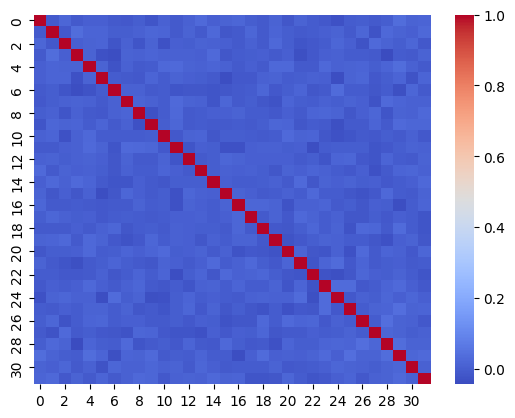

In [12]:
# correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = np.corrcoef(x_embeddings.detach().cpu().numpy(), rowvar=False)
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()